In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention, CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf700 = pd.read_json('evaluation_set/deepnofakes/dnf_700/initial.json')
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
dnf_eval.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles300 = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors300 = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf700.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'claim_ids', 'evidence', 'headline', 'id', 'reason',
        'claims', 'type', 'urls'],
       dtype='object'),
 Index(['authors', 'headline', 'id', 'type', 'urls'], dtype='object'),
 705,
 705)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 500
# for idx in articles.keys():
#     num = len(articles[idx])
#     if num>=max_sentences:
#         max_sentences = num
        
max_sentences

500

In [5]:
hdl = "George Soros: Trump Will Win Popular Vote by a Landslide but Clinton Victory a 'Done Deal'"
hdl = "Ted Cruz Said 'If Something Happens to Hillary' He'll 'Run as a Democrat Against Trump'"
# hdl = "If You Thought The Trump Child Rape Case In NY Couldn’t Get Much Worse — You Were Wrong"
# hdl = "California Set to Let Public Schools Teach Primarily in Spanish"
dnf700[dnf700.headline==hdl]

,authors,headline,id,type,urls


In [6]:
titles = sorted(dnf700.headline.unique())
len(titles)

698

In [7]:
test_titles = sorted(dnf_eval.headline.unique())
len(test_titles)
test_titles

['(VIDEO) Female College Students Protesting Because ‘Trump is a Rapist’',
 'Assange Confirms: WikiLeaks Didn’t Get Emails From Russian Govt',
 'BREAKING: Fraudulent Clinton Votes Discovered By The Tens Of Thousands',
 "Clinton Camp Demands 'Compliant Citizenry' for Master Plan",
 'Clinton Received Debate Questions Week Before Debate',
 "DOJ's Loretta Lynch Tried To Squash Comey's Letter To Congress",
 'Department of Homeland Security Chairman Officially Indicts Hillary Clinton of Treason',
 'Developing: Obama WH admits that Hillary gave ISIS $400 million on accident',
 'Erdoğan: US, the founder of ISIS',
 "FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 'FBI Agent Suspected in Hillary Email Leaks Found Dead in Apparent Murder-Suicide',
 'FBI Director Comey’s ‘Leaked’ Memo Explains Why He’s Reopening the Clinton Email Case',
 'FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes',
 'Fo

In [8]:
non_test_titles = np.array(list(set(titles)-set(test_titles)))
len(non_test_titles)

653

In [9]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [10]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

(523, 130, 50)

In [11]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [12]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            sentences = articles300[ar_id]
            vectors = article_vectors300[ar_id]
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
                sentences=articles[ar_id]
                vectors = article_vectors[ar_id]
            except Exception as ex:
                print(ex)
                print(idx)
            
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [13]:
tdg = datagen_dnf(train_batchsize,dnf700,mode='train')
vdg = datagen_dnf(val_batchsize,dnf700,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf700,mode='test')

In [14]:
x,y = next(test_dg)

In [15]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

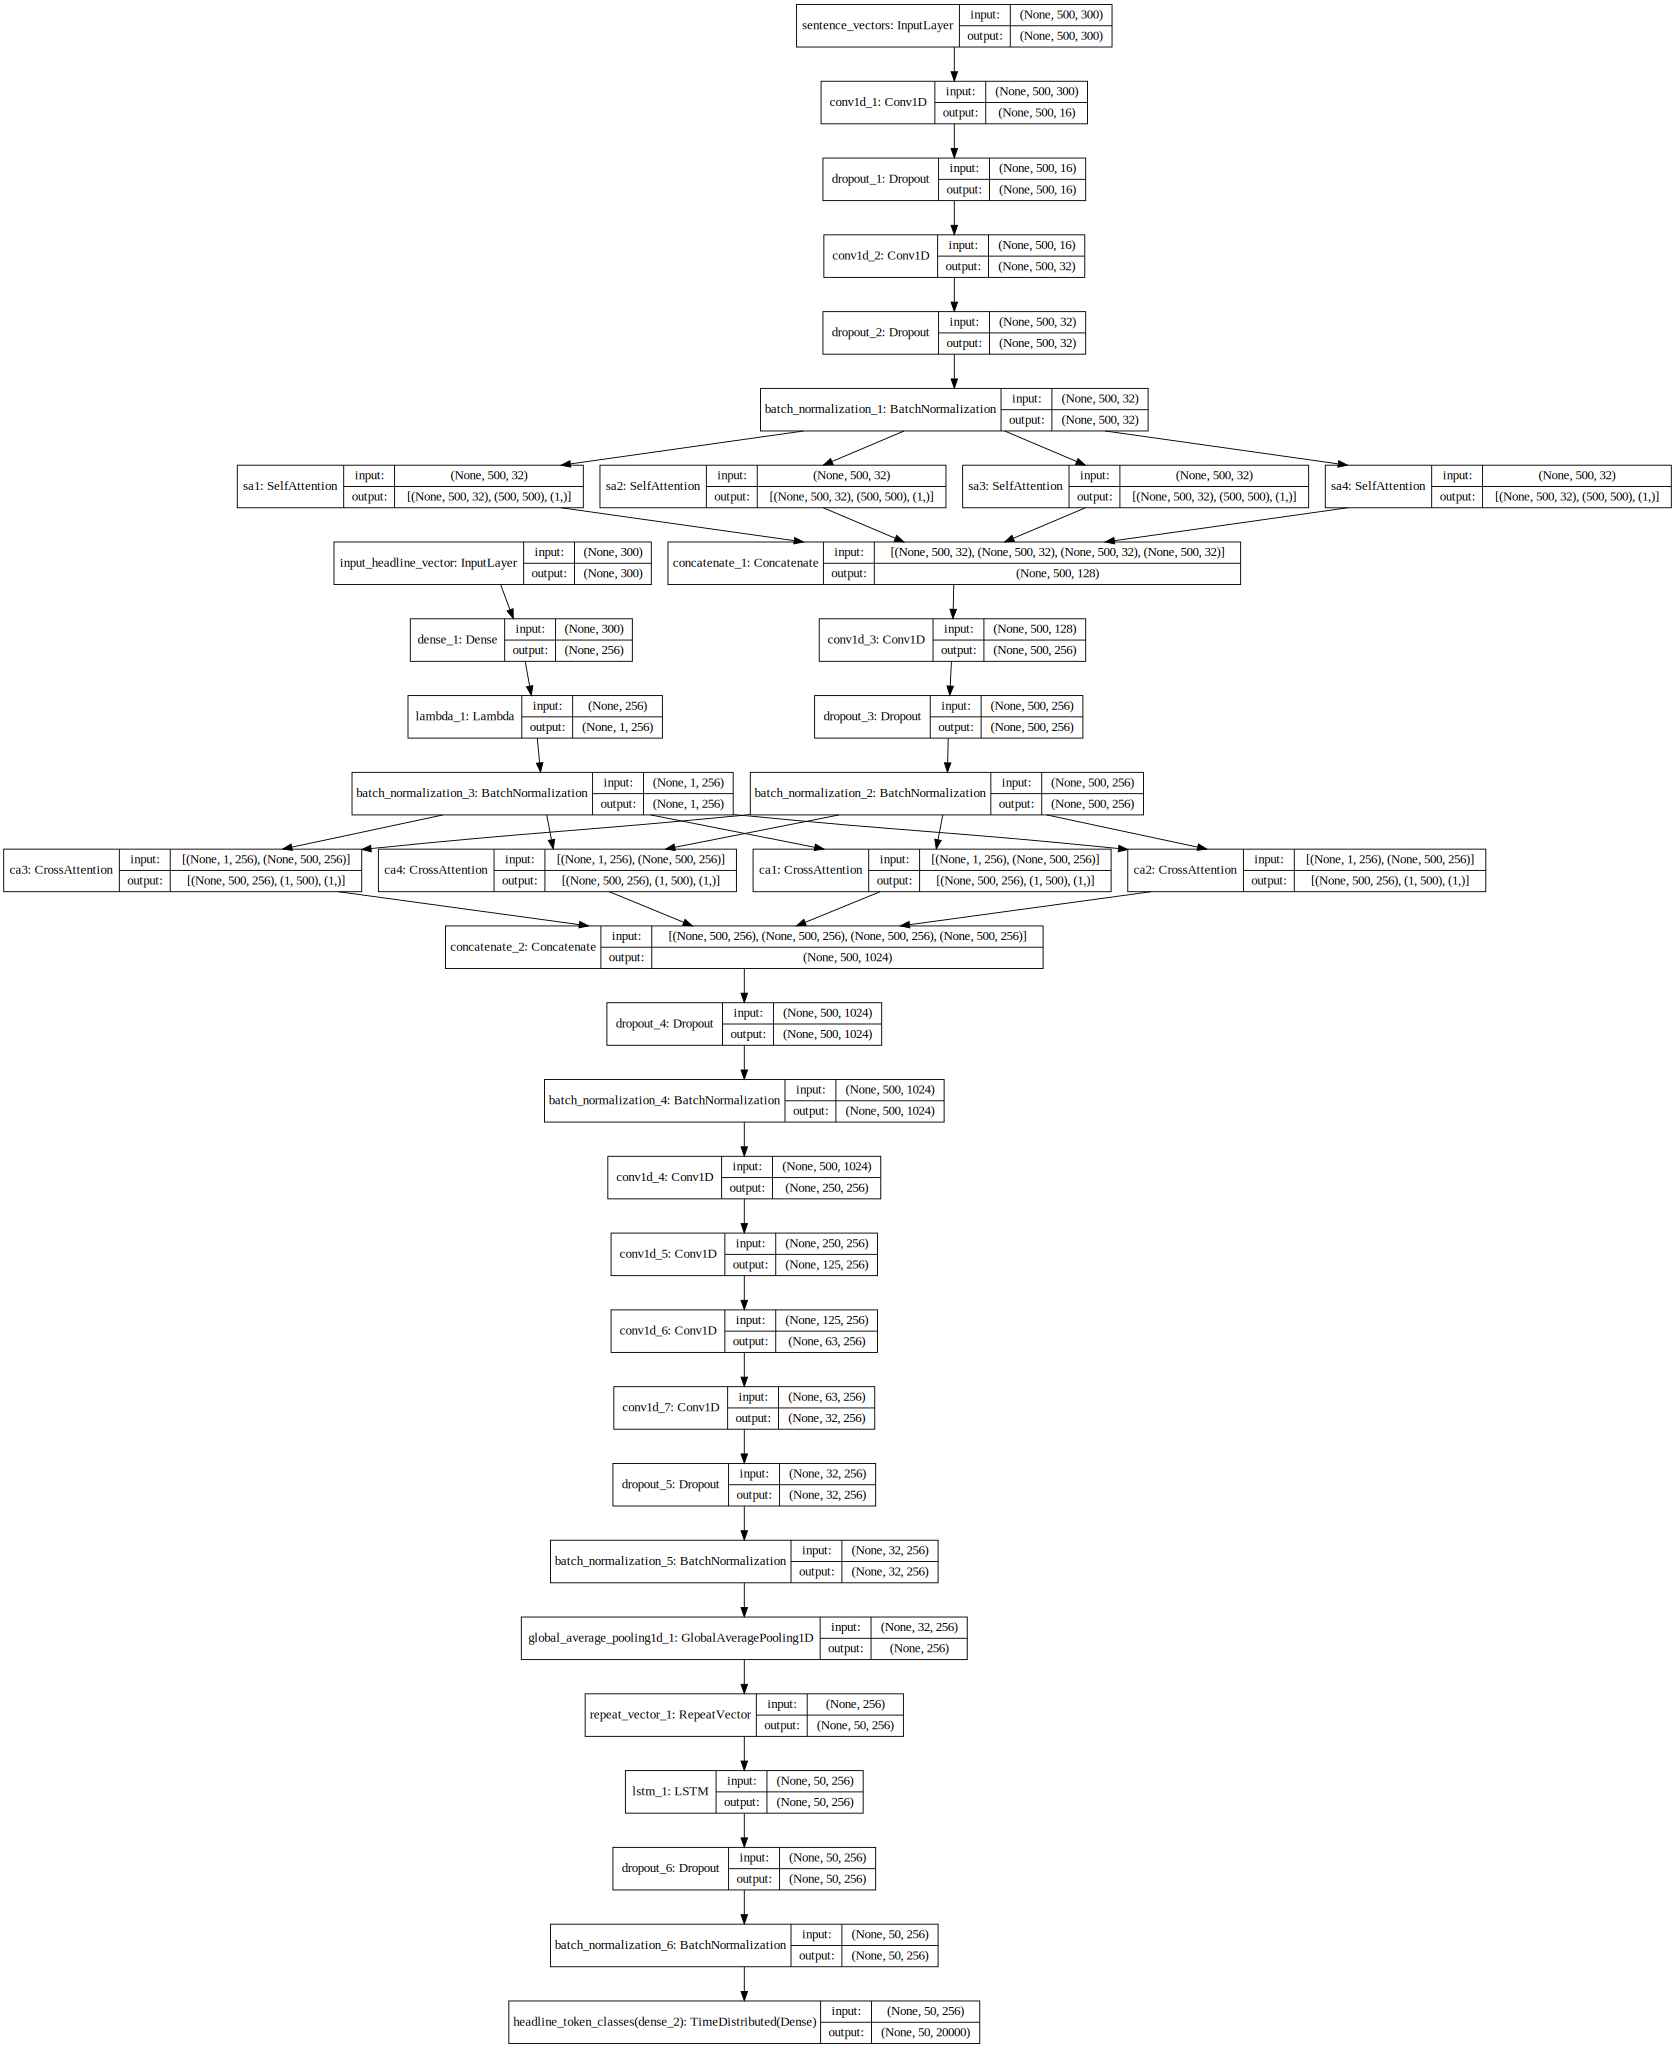

In [16]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
    repeat = RepeatVector(50)(gap)
    lstm1 = LSTM(256,return_sequences=True, activation='relu')(repeat)
    lstm1 = Dropout(0.5)(lstm1)
    lstm1 = BatchNormalization()(lstm1)
    gen_hd_vector = TimeDistributed(Dense(20000,activation='softmax'), name='headline_token_classes')(lstm1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [17]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf700_sa_sent_hd_word_gl.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf700_sa_sent_hd_word_gl/{0}'.format(dt.timestamp()),write_graph=True)

In [18]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 34s 9s/step - loss: 9.9134 - acc: 0.0000e+00 - val_loss: 9.7867 - val_acc: 0.0000e+00
Epoch 2/2000
4/4 [==============================] - 2s 386ms/step - loss: 9.9081 - acc: 0.0000e+00 - val_loss: 9.7842 - val_acc: 0.0000e+00
Epoch 3/2000
4/4 [==============================] - 2s 452ms/step - loss: 9.8995 - acc: 1.5625e-04 - val_loss: 9.7852 - val_acc: 0.0000e+00
Epoch 4/2000
4/4 [==============================] - 2s 457ms/step - loss: 9.8916 - acc: 1.5625e-04 - val_loss: 9.7462 - val_acc: 0.0219
Epoch 5/2000
4/4 [==============================] - 9s 2s/step - loss: 9.8841 - acc: 7.8125e-04 - val_loss: 9.7367 - val_acc: 0.0213
Epoch 6/2000
4/4 [==============================] - 8s 2s/step - loss: 9.8761 - acc: 0.0017 - val_loss: 9.6989 - val_acc: 0.6894
Epoch 7/2000
4/4 [==============================] - 9s 2s/step - loss: 9.8687 - acc: 0.0048 - val_loss: 9.7474 - val_acc: 0.6375
Epoch 8/2000
4/4 [==============================] - 9s 

4/4 [==============================] - 16s 4s/step - loss: 7.9358 - acc: 0.5942 - val_loss: 9.0764 - val_acc: 0.6313
Epoch 126/2000
4/4 [==============================] - 16s 4s/step - loss: 7.8481 - acc: 0.5827 - val_loss: 9.1406 - val_acc: 0.6300
Epoch 127/2000
4/4 [==============================] - 16s 4s/step - loss: 7.8430 - acc: 0.5908 - val_loss: 9.1611 - val_acc: 0.6325
Epoch 128/2000
4/4 [==============================] - 15s 4s/step - loss: 7.7365 - acc: 0.6083 - val_loss: 9.1505 - val_acc: 0.6388
Epoch 129/2000
4/4 [==============================] - 15s 4s/step - loss: 7.7278 - acc: 0.5908 - val_loss: 9.1621 - val_acc: 0.6325
Epoch 130/2000
4/4 [==============================] - 15s 4s/step - loss: 7.6572 - acc: 0.6070 - val_loss: 9.1436 - val_acc: 0.6294
Epoch 131/2000
4/4 [==============================] - 16s 4s/step - loss: 7.6408 - acc: 0.5906 - val_loss: 9.2143 - val_acc: 0.6313
Epoch 132/2000
4/4 [==============================] - 15s 4s/step - loss: 7.6414 - acc: 0.5

4/4 [==============================] - 16s 4s/step - loss: 3.7934 - acc: 0.6977 - val_loss: 5.9387 - val_acc: 0.7000
Epoch 250/2000
4/4 [==============================] - 16s 4s/step - loss: 3.7571 - acc: 0.7033 - val_loss: 6.1660 - val_acc: 0.7044
Epoch 251/2000
4/4 [==============================] - 16s 4s/step - loss: 3.7060 - acc: 0.7053 - val_loss: 6.0067 - val_acc: 0.7275
Epoch 252/2000
4/4 [==============================] - 14s 4s/step - loss: 3.9343 - acc: 0.7000 - val_loss: 6.1091 - val_acc: 0.7100
Epoch 253/2000
4/4 [==============================] - 16s 4s/step - loss: 3.6473 - acc: 0.7084 - val_loss: 5.7986 - val_acc: 0.7237
Epoch 254/2000
4/4 [==============================] - 16s 4s/step - loss: 3.5966 - acc: 0.7145 - val_loss: 5.8239 - val_acc: 0.7206
Epoch 255/2000
4/4 [==============================] - 15s 4s/step - loss: 3.6860 - acc: 0.7003 - val_loss: 5.8286 - val_acc: 0.7200
Epoch 256/2000
4/4 [==============================] - 15s 4s/step - loss: 3.6120 - acc: 0.7

4/4 [==============================] - 15s 4s/step - loss: 2.5471 - acc: 0.7366 - val_loss: 4.2556 - val_acc: 0.7075
Epoch 374/2000
4/4 [==============================] - 15s 4s/step - loss: 2.4750 - acc: 0.7508 - val_loss: 3.9012 - val_acc: 0.7362
Epoch 375/2000
4/4 [==============================] - 16s 4s/step - loss: 2.5074 - acc: 0.7414 - val_loss: 4.0300 - val_acc: 0.7231
Epoch 376/2000
4/4 [==============================] - 16s 4s/step - loss: 2.5169 - acc: 0.7409 - val_loss: 4.1305 - val_acc: 0.7231
Epoch 377/2000
4/4 [==============================] - 16s 4s/step - loss: 2.4673 - acc: 0.7431 - val_loss: 4.0543 - val_acc: 0.7250
Epoch 378/2000
4/4 [==============================] - 16s 4s/step - loss: 2.5330 - acc: 0.7384 - val_loss: 4.0414 - val_acc: 0.7312
Epoch 379/2000
4/4 [==============================] - 16s 4s/step - loss: 2.3865 - acc: 0.7488 - val_loss: 4.1447 - val_acc: 0.7150
Epoch 380/2000
4/4 [==============================] - 15s 4s/step - loss: 2.3825 - acc: 0.7

4/4 [==============================] - 15s 4s/step - loss: 2.0422 - acc: 0.7402 - val_loss: 2.2245 - val_acc: 0.7738
Epoch 498/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8579 - acc: 0.7623 - val_loss: 2.5736 - val_acc: 0.7344
Epoch 499/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8656 - acc: 0.7534 - val_loss: 2.3135 - val_acc: 0.7581
Epoch 500/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9170 - acc: 0.7520 - val_loss: 2.3004 - val_acc: 0.7650
Epoch 501/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7843 - acc: 0.7653 - val_loss: 2.4774 - val_acc: 0.7375
Epoch 502/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8532 - acc: 0.7566 - val_loss: 2.3278 - val_acc: 0.7556
Epoch 503/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7909 - acc: 0.7600 - val_loss: 2.4781 - val_acc: 0.7494
Epoch 504/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8178 - acc: 0.7

4/4 [==============================] - 15s 4s/step - loss: 1.8241 - acc: 0.7447 - val_loss: 2.7155 - val_acc: 0.7344
Epoch 622/2000
4/4 [==============================] - 14s 4s/step - loss: 1.7318 - acc: 0.7612 - val_loss: 2.2497 - val_acc: 0.7700
Epoch 623/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8574 - acc: 0.7439 - val_loss: 2.6109 - val_acc: 0.7387
Epoch 624/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8060 - acc: 0.7503 - val_loss: 2.7199 - val_acc: 0.7237
Epoch 625/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7005 - acc: 0.7628 - val_loss: 2.2867 - val_acc: 0.7681
Epoch 626/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8557 - acc: 0.7495 - val_loss: 2.6777 - val_acc: 0.7325
Epoch 627/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8380 - acc: 0.7423 - val_loss: 2.0829 - val_acc: 0.7825
Epoch 628/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7810 - acc: 0.7

4/4 [==============================] - 16s 4s/step - loss: 1.8658 - acc: 0.7602 - val_loss: 2.3353 - val_acc: 0.7569
Epoch 746/2000
4/4 [==============================] - 16s 4s/step - loss: 2.0059 - acc: 0.7409 - val_loss: 2.5137 - val_acc: 0.7412
Epoch 747/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9466 - acc: 0.7480 - val_loss: 2.2935 - val_acc: 0.7606
Epoch 748/2000
4/4 [==============================] - 17s 4s/step - loss: 1.9586 - acc: 0.7466 - val_loss: 2.4394 - val_acc: 0.7475
Epoch 749/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8816 - acc: 0.7547 - val_loss: 2.1940 - val_acc: 0.7606
Epoch 750/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9751 - acc: 0.7439 - val_loss: 2.2040 - val_acc: 0.7631
Epoch 751/2000
4/4 [==============================] - 16s 4s/step - loss: 1.9247 - acc: 0.7625 - val_loss: 2.3420 - val_acc: 0.7506
Epoch 752/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9654 - acc: 0.7

4/4 [==============================] - 14s 3s/step - loss: 1.7522 - acc: 0.7603 - val_loss: 2.0721 - val_acc: 0.7781
Epoch 870/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6267 - acc: 0.7742 - val_loss: 2.3236 - val_acc: 0.7525
Epoch 871/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7290 - acc: 0.7603 - val_loss: 2.1364 - val_acc: 0.7756
Epoch 872/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7957 - acc: 0.7527 - val_loss: 2.3150 - val_acc: 0.7600
Epoch 873/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7294 - acc: 0.7656 - val_loss: 2.3605 - val_acc: 0.7600
Epoch 874/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7704 - acc: 0.7555 - val_loss: 2.4935 - val_acc: 0.7450
Epoch 875/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7427 - acc: 0.7612 - val_loss: 2.2926 - val_acc: 0.7556
Epoch 876/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8422 - acc: 0.7

4/4 [==============================] - 15s 4s/step - loss: 1.6497 - acc: 0.7655 - val_loss: 2.5822 - val_acc: 0.7419
Epoch 994/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7201 - acc: 0.7589 - val_loss: 2.7029 - val_acc: 0.7237
Epoch 995/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7426 - acc: 0.7544 - val_loss: 2.3053 - val_acc: 0.7619
Epoch 996/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7565 - acc: 0.7508 - val_loss: 2.6856 - val_acc: 0.7212
Epoch 997/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7192 - acc: 0.7553 - val_loss: 2.6534 - val_acc: 0.7375
Epoch 998/2000
4/4 [==============================] - 14s 4s/step - loss: 1.6856 - acc: 0.7625 - val_loss: 2.9920 - val_acc: 0.7106
Epoch 999/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7192 - acc: 0.7584 - val_loss: 2.8969 - val_acc: 0.7169
Epoch 1000/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8024 - acc: 0.

Epoch 1055/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7666 - acc: 0.7498 - val_loss: 2.4784 - val_acc: 0.7550
Epoch 1056/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8360 - acc: 0.7416 - val_loss: 2.7098 - val_acc: 0.7256
Epoch 1057/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7905 - acc: 0.7477 - val_loss: 2.5000 - val_acc: 0.7538
Epoch 1058/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8013 - acc: 0.7478 - val_loss: 2.7110 - val_acc: 0.7319
Epoch 1059/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7442 - acc: 0.7556 - val_loss: 2.6598 - val_acc: 0.7450
Epoch 1060/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7329 - acc: 0.7516 - val_loss: 2.7090 - val_acc: 0.7294
Epoch 1061/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8297 - acc: 0.7405 - val_loss: 2.5592 - val_acc: 0.7531
Epoch 1062/2000
4/4 [==============================] - 16s 4s/step - 

Epoch 1178/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7818 - acc: 0.7472 - val_loss: 2.7592 - val_acc: 0.7356
Epoch 1179/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6699 - acc: 0.7603 - val_loss: 2.6803 - val_acc: 0.7406
Epoch 1180/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6392 - acc: 0.7638 - val_loss: 3.0242 - val_acc: 0.7131
Epoch 1181/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7466 - acc: 0.7569 - val_loss: 3.1253 - val_acc: 0.7113
Epoch 1182/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7457 - acc: 0.7533 - val_loss: 2.7299 - val_acc: 0.7381
Epoch 1183/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6836 - acc: 0.7600 - val_loss: 2.7213 - val_acc: 0.7294
Epoch 1184/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8104 - acc: 0.7488 - val_loss: 2.7612 - val_acc: 0.7319
Epoch 1185/2000
4/4 [==============================] - 16s 4s/step - 

Epoch 1301/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6956 - acc: 0.7608 - val_loss: 2.3250 - val_acc: 0.7619
Epoch 1302/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7125 - acc: 0.7534 - val_loss: 2.7320 - val_acc: 0.7337
Epoch 1303/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6099 - acc: 0.7684 - val_loss: 2.8757 - val_acc: 0.7237
Epoch 1304/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6366 - acc: 0.7653 - val_loss: 2.5782 - val_acc: 0.7400
Epoch 1305/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6313 - acc: 0.7638 - val_loss: 2.5396 - val_acc: 0.7594
Epoch 1306/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6781 - acc: 0.7564 - val_loss: 2.5953 - val_acc: 0.7450
Epoch 1307/2000
4/4 [==============================] - 17s 4s/step - loss: 1.6431 - acc: 0.7625 - val_loss: 2.6277 - val_acc: 0.7444
Epoch 1308/2000
4/4 [==============================] - 16s 4s/step - 

Epoch 1424/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7526 - acc: 0.7464 - val_loss: 2.1726 - val_acc: 0.7669
Epoch 1425/2000
4/4 [==============================] - 15s 4s/step - loss: 1.6574 - acc: 0.7630 - val_loss: 2.6807 - val_acc: 0.7362
Epoch 1426/2000
4/4 [==============================] - 16s 4s/step - loss: 1.6867 - acc: 0.7558 - val_loss: 2.4970 - val_acc: 0.7375
Epoch 1427/2000
4/4 [==============================] - 14s 4s/step - loss: 1.6722 - acc: 0.7584 - val_loss: 2.5420 - val_acc: 0.7513
Epoch 1428/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8108 - acc: 0.7366 - val_loss: 2.4180 - val_acc: 0.7406
Epoch 1429/2000
4/4 [==============================] - 14s 3s/step - loss: 1.6885 - acc: 0.7537 - val_loss: 2.7468 - val_acc: 0.7237
Epoch 1430/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7596 - acc: 0.7462 - val_loss: 2.6101 - val_acc: 0.7356
Epoch 1431/2000
4/4 [==============================] - 16s 4s/step - 

Epoch 1547/2000
4/4 [==============================] - 15s 4s/step - loss: 2.1155 - acc: 0.7563 - val_loss: 2.5067 - val_acc: 0.7425
Epoch 1548/2000
4/4 [==============================] - 15s 4s/step - loss: 2.0392 - acc: 0.7645 - val_loss: 2.2198 - val_acc: 0.7675
Epoch 1549/2000
4/4 [==============================] - 15s 4s/step - loss: 2.1050 - acc: 0.7580 - val_loss: 2.3443 - val_acc: 0.7563
Epoch 1550/2000
4/4 [==============================] - 14s 4s/step - loss: 2.0634 - acc: 0.7638 - val_loss: 2.2568 - val_acc: 0.7688
Epoch 1551/2000
4/4 [==============================] - 14s 4s/step - loss: 2.1947 - acc: 0.7487 - val_loss: 2.4309 - val_acc: 0.7519
Epoch 1552/2000
4/4 [==============================] - 15s 4s/step - loss: 2.1010 - acc: 0.7605 - val_loss: 2.6308 - val_acc: 0.7425
Epoch 1553/2000
4/4 [==============================] - 15s 4s/step - loss: 2.3192 - acc: 0.7373 - val_loss: 2.3298 - val_acc: 0.7638
Epoch 1554/2000
4/4 [==============================] - 16s 4s/step - 

Epoch 1670/2000
4/4 [==============================] - 15s 4s/step - loss: 2.0741 - acc: 0.7372 - val_loss: 2.3596 - val_acc: 0.7569
Epoch 1671/2000
4/4 [==============================] - 14s 4s/step - loss: 1.8542 - acc: 0.7669 - val_loss: 2.5617 - val_acc: 0.7231
Epoch 1672/2000
4/4 [==============================] - 15s 4s/step - loss: 2.0082 - acc: 0.7480 - val_loss: 2.6115 - val_acc: 0.7412
Epoch 1673/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9218 - acc: 0.7566 - val_loss: 2.4776 - val_acc: 0.7487
Epoch 1674/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9731 - acc: 0.7498 - val_loss: 2.3919 - val_acc: 0.7513
Epoch 1675/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9073 - acc: 0.7511 - val_loss: 2.3982 - val_acc: 0.7519
Epoch 1676/2000
4/4 [==============================] - 15s 4s/step - loss: 1.9276 - acc: 0.7544 - val_loss: 2.5489 - val_acc: 0.7356
Epoch 1677/2000
4/4 [==============================] - 15s 4s/step - 

Epoch 1793/2000
4/4 [==============================] - 15s 4s/step - loss: 1.8085 - acc: 0.7544 - val_loss: 2.4026 - val_acc: 0.7425
Epoch 1794/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8057 - acc: 0.7555 - val_loss: 2.6478 - val_acc: 0.7375
Epoch 1795/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7335 - acc: 0.7652 - val_loss: 2.4922 - val_acc: 0.7350
Epoch 1796/2000
4/4 [==============================] - 16s 4s/step - loss: 1.7854 - acc: 0.7527 - val_loss: 2.3186 - val_acc: 0.7556
Epoch 1797/2000
4/4 [==============================] - 16s 4s/step - loss: 1.8943 - acc: 0.7406 - val_loss: 2.5648 - val_acc: 0.7294
Epoch 1798/2000
4/4 [==============================] - 17s 4s/step - loss: 1.7054 - acc: 0.7681 - val_loss: 2.1355 - val_acc: 0.7756
Epoch 1799/2000
4/4 [==============================] - 15s 4s/step - loss: 1.7559 - acc: 0.7575 - val_loss: 2.4234 - val_acc: 0.7462
Epoch 1800/2000
4/4 [==============================] - 16s 4s/step - 

Epoch 1916/2000
4/4 [==============================] - 12s 3s/step - loss: 1.8573 - acc: 0.7397 - val_loss: 2.2912 - val_acc: 0.7494
Epoch 1917/2000
4/4 [==============================] - 12s 3s/step - loss: 1.7089 - acc: 0.7569 - val_loss: 2.4056 - val_acc: 0.7525
Epoch 1918/2000
4/4 [==============================] - 12s 3s/step - loss: 1.8314 - acc: 0.7394 - val_loss: 2.5318 - val_acc: 0.7306
Epoch 1919/2000
4/4 [==============================] - 12s 3s/step - loss: 1.7698 - acc: 0.7459 - val_loss: 2.0916 - val_acc: 0.7788
Epoch 1920/2000
4/4 [==============================] - 12s 3s/step - loss: 1.7762 - acc: 0.7458 - val_loss: 2.4065 - val_acc: 0.7481
Epoch 1921/2000
4/4 [==============================] - 11s 3s/step - loss: 1.7354 - acc: 0.7503 - val_loss: 2.7123 - val_acc: 0.7163
Epoch 1922/2000
4/4 [==============================] - 11s 3s/step - loss: 1.7508 - acc: 0.7492 - val_loss: 2.6318 - val_acc: 0.7375
Epoch 1923/2000
4/4 [==============================] - 11s 3s/step - 

In [19]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [20]:
# df_res = pd.DataFrame(hist.history)

In [21]:
# df_res[['loss','val_loss']].plot()

In [22]:
# # df_res[['acc','val_acc']].plot()
# hd_nlp = nlp("What is you name my name is Anthony Gonsalves What is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony Gonsalves!".lower())
# len(hd_nlp[:50])

# Evalutate SST

In [23]:
model.load_weights('weights/dnf700_sa_sent_hd_word_gl.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., use_multiprocessing=True, steps=5)`
  


[2.463012361526489, 0.7322400093078614]

In [24]:
x,y = next(test_dg)
pred = model.predict(x)

In [25]:
x['headline']

array(['department of homeland security chairman officially indicts hillary clinton of treason',
       "george soros: trump will win popular vote by a landslide but clinton victory a 'done deal'",
       'former nato chief: we need us as ‘world’s policeman’',
       'clinton received debate questions week before debate',
       "george soros: trump will win popular vote by a landslide but clinton victory a 'done deal'",
       'breaking: fraudulent clinton votes discovered by the tens of thousands',
       "doj's loretta lynch tried to squash comey's letter to congress",
       "fantastic! trump's 7 point plan to reform healthcare begins with a bombshell! » 100percentfedup.com",
       "george soros: trump will win popular vote by a landslide but clinton victory a 'done deal'",
       'hillary’s (islamic) america is already here where ‘muslim no-go zones’ are popping up all over michiganistan',
       'president obama confirms he will refuse to leave office if trump is elected',
     

In [26]:
test_idx = np.random.randint(0,50)
display(x['headline'][test_idx])

'former nato chief: we need us as ‘world’s policeman’'

In [27]:
x['sentences'][test_idx]

['In a new interview with Britain’s Sky News, former NATO Secretary-General Anders Fogh Rasmussen brought out the old narrative of America as the “world’s policeman,” but with a lot more upbeat of an attitude about it than one would generally see.',
 'Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars.',
 'Rasmussen, who was always a relative hawk in the post but seems to have taken it to an entirely new level, set out a series of things the US needs to fix militarily, including Iraq, Syria, Libya, Russia, China, and North Korea.',
 'This of course closely mirrors recent Pentagon talk of wars in the decades to come.',
 'The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinto

# Model Test

In [28]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 500, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 500, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 500, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [29]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [30]:
b = b1+b2+b3+b4

In [31]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([3, 4, 2, 5, 1])

In [32]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

6


101.703926

In [33]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

'former nato chief: we need us as ‘world’s policeman’'

['In a new interview with Britain’s Sky News, former NATO Secretary-General Anders Fogh Rasmussen brought out the old narrative of America as the world’s policeman, but with a lot more upbeat of an attitude about it than one would generally see.',
 'Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring  we need America as the world’s policeman,  adding that the US needs to restore international law and order through wars.',
 'The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinton, who has campaigned heavily on picking fights in Syria and against Russia.',
 'Rasmussen underscored this fact by declaring Donald Trump, who openly said the US cannot be the world’s police, as very dangerous for the world.']

In [34]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

3 : This of course closely mirrors recent Pentagon talk of wars in the decades to come.
4 : The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinton, who has campaigned heavily on picking fights in Syria and against Russia.
2 : Rasmussen, who was always a relative hawk in the post but seems to have taken it to an entirely new level, set out a series of things the US needs to fix militarily, including Iraq, Syria, Libya, Russia, China, and North Korea.
5 : Rasmussen underscored this fact by declaring Donald Trump, who openly said the US cannot be the world’s police, as “very dangerous for the world.”
1 : Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars.


In [35]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

6


101.703926

In [36]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

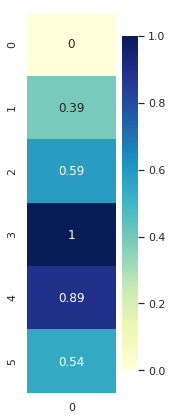

In [37]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [38]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 500, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 16)           14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 32)           128       
_________________________________________________________________
sa1 (SelfAttention)          [(None, 500, 32), (500, 5 2377      
Total para

In [39]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [40]:
sb = sb1[test_idx]#+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(6, 6)

In [41]:
df_sb = pd.DataFrame(sb)


# zx = df_sb.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# zx_scaled = min_max_scaler.fit_transform(zx)
# df_sb = pd.DataFrame(zx_scaled)

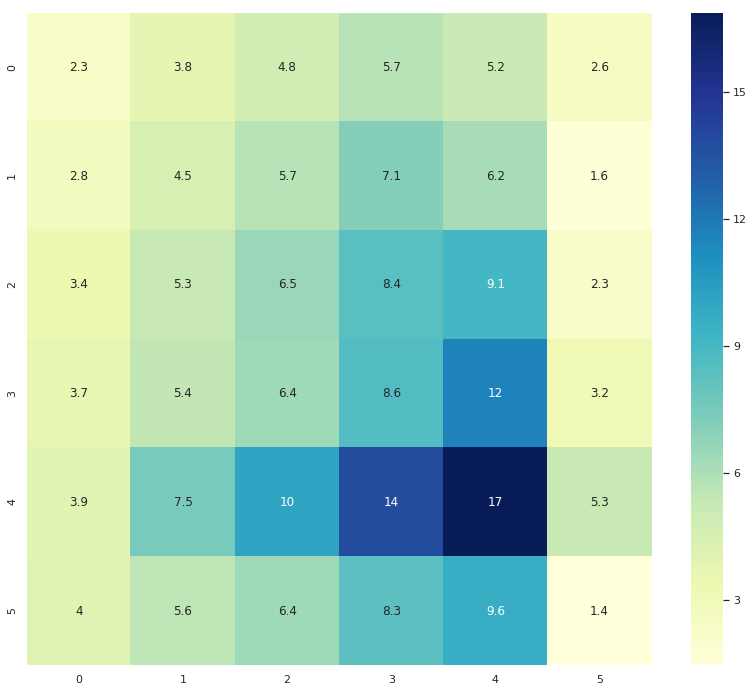

In [42]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [43]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,"In a new interview with Britain’s Sky News, former NATO Secretary-General Anders Fogh Rasmussen brought out the old narrative of America as the “world’s policeman,” but with a lot more upbeat of an attitude about it than one would generally see."
1,"Rasmussen criticized President Obama for not being hawkish enough, saying his successor needs to be much more interventionist, and declaring “ we need America as the world’s policeman, ” adding that the US needs to “restore international law and order” through wars."
2,"Rasmussen, who was always a relative hawk in the post but seems to have taken it to an entirely new level, set out a series of things the US needs to fix militarily, including Iraq, Syria, Libya, Russia, China, and North Korea."
3,This of course closely mirrors recent Pentagon talk of wars in the decades to come.
4,"The timing of his calls for extreme US bellicosity are centered on trying to influence the upcoming US election in favor of Democratic nominee Hillary Clinton, who has campaigned heavily on picking fights in Syria and against Russia."
5,"Rasmussen underscored this fact by declaring Donald Trump, who openly said the US cannot be the world’s police, as “very dangerous for the world.”"


In [44]:

def datagen_dnf_eval():

    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]

    for idx in dnf_eval.id: 
        hd = dnf_eval[dnf_eval.id==idx]['headline'].values[0].lower()
        ar_id = dnf_eval[dnf_eval.id==idx]['id'].values[0]
        cl = dnf_eval[dnf_eval.id==idx]['claim_ids'].values[0]
        ar_claims.append(cl)
        sentences = articles300[ar_id]
        vectors = article_vectors300[ar_id]


        hds.append(hd)
        ar_sentences.append(sentences)
    #         print(len(sentences))
        sents = np.zeros((max_sentences,300))

        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))

        inputs = {
            'article_id': np.array(ar_ids)
            ,'headline': np.array(hds)
            ,'sentence_vectors' : np.array(ar_sents)
            ,'input_headline_vector': np.array(ar_head_vectors)
            ,'claims':np.array(ar_claims)
            ,'sentences':np.array(ar_sentences)
        }
        outputs = {
            'headline_token_classes': np.array(ar_head_classes)
            ,'output_headline_vector': np.array(ar_head_vectors)
        }
    return inputs,outputs
testX,testY = datagen_dnf_eval()

In [45]:

# display(testX['headline'])

# Evaluation for P, R, F1

In [46]:

best_N = 5
_, b1, g1 = model_1.predict(testX)
_, b2, g2 = model_2.predict(testX)
_, b3, g3 = model_3.predict(testX)
_, b4, g4 = model_4.predict(testX)
ps, rs = [],[]
counter=0
for test_idx in range(len(testX['headline'])):    
    tp,fp,fn = 0,0,0
    claims = np.array(testX['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    pred = b[0][:len(testX['sentences'][test_idx])].argsort()[-best_N:][::-1]
    
#     print('claims:',claims)
#     print('pred:',pred)
    for p in pred:
        if p in claims:
            tp+=1
        else:
            fp+=1
    for c in claims:
        if c not in pred:
            fn+=1
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)
#     counter+=1
#     if counter==5:
#         break
#     print("----------------------------")
#     for s in t:
#         if s>=len(x['sentences'][test_idx]):continue
#         x['sentences'][test_idx][s]
np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.401, 0.5546666666666666, 0.4654788978025811)

In [47]:
df_hd_tp_cdc = pd.read_csv('evaluation_set/cdc_ibm/headline_topic_mapping.csv')
df_ar_cl_cdc = pd.read_csv('evaluation_set/cdc_ibm/article_claim_mapping.csv')
df_hd_tp_dnf = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V4.json')
df_hd_tp_dnf.columns = ['authors','claim_ids', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls']
with open('evaluation_set/cdc_ibm/articles.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/cdc_ibm/article_vectors.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
df_hd_tp_cdc.keys(),df_ar_cl_cdc.keys(), len(articles.keys()), len(article_vectors.keys()), df_hd_tp_dnf.keys()
test_titles = []
for ar in df_ar_cl_cdc.Article.unique():
    if len(df_ar_cl_cdc[df_ar_cl_cdc.Article==ar]['Claim'].values)>8:
        test_titles.append(ar)
ar_ids,ar_sents,ar_sentences,ar_head_vectors,ar_head_classes,hds,claims=[],[],[],[],[],[],[]
for idx in tqdm_notebook(test_titles):
#     print(idx)
    hd = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['Headline'].values[0].lower()
    hds.append(hd)
    ar_id = df_hd_tp_cdc[df_hd_tp_cdc.Title==idx]['article Id'].values[0]
    cl = df_ar_cl_cdc[df_ar_cl_cdc.Article==idx]['Claim'].values
    claims.append(cl)
#     sentences=articles[ar_id]
#     ar_sentences.append(ar_sentences)
    #         print(len(sentences))
    sents = np.zeros((max_sentences,300))
    vectors = article_vectors[ar_id]
    sents[:len(vectors)] = vectors[:max_sentences]
    ar_ids.append(ar_id)
    ar_sents.append(sents)
    hd_nlp = nlp(hd.lower())
    head_classes = np.zeros(50, dtype='int')
    for i in range(len(hd_nlp)):
        head_classes[i] = hd_nlp[i].rank
    ar_head_vectors.append(hd_nlp.vector)
    ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
inputs = {
    'article_id': np.array(ar_ids)
    ,'headline': np.array(hds)
    ,'sentence_vectors' : np.array(ar_sents)
#     ,'sentences' : np.array(ar_sentences)
    ,'input_headline_vector': np.array(ar_head_vectors)
    ,'claims':np.array(claims)
}
outputs = {
    'headline_token_classes': np.array(ar_head_classes)
    ,'output_headline_vector': np.array(ar_head_vectors)
}
threshold = 0.95
best_N = 5
_, b1, g1 = model_1.predict(inputs)
_, b2, g2 = model_2.predict(inputs)
_, b3, g3 = model_3.predict(inputs)
_, b4, g4 = model_4.predict(inputs)
ps, rs = [],[]
counter=0
for test_idx in tqdm_notebook(range(len(inputs['headline']))):    
    tp,fp,fn = 0,0,0
    claims = np.array(inputs['claims'][test_idx])
#     sentences = list(range(len(articles[test_idx])))
    b = b1[test_idx]+b2[test_idx]+b3[test_idx]+b4[test_idx]
    ids = b[0][:len(articles[inputs['article_id'][test_idx]])].argsort()[-best_N:][::-1]
#     print(ids)
    pred = np.array(articles[inputs['article_id'][test_idx]])[ids]
#     print('claims:',claims)
#     print('pred:',pred)
    for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
        t5 = nlp(str(pred[i]))
        flag = False
        #pred_claim_sent.append(pred[i])
    #     print(t5.vector)
        for j in range(len(cl)):
            _c = nlp(cl[j])
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                tp+=1
                flag = True
                break
        if flag is False:
            fp+=1
        
            
   
    #     print(t5.vector)
    for j in range(len(cl)):
        _c = nlp(cl[j])
        flag = False
        for i in range(len(pred)):
    #     print('===========***********',i,'***********============')
            t5 = nlp(str(pred[i]))
        
    #         print(_c.vector)
    #         print('top_5:',t5.text)
    #         print('-------------------')
    #         print('ground_truth:',_c.text)
    #         print('t5:{0}, cl:{1}, sim: {2}'.format(i,j,np.around(t5.similarity(_c),4)))
    #         print('===================================================================')
            if np.around(t5.similarity(_c),4) > threshold:
                flag = True
                break
        if flag is False:
            fn+=1
         
    p = tp/(tp+fp)
    r = tp/(tp+fn)
#     print()
#     tn = sentences - list(set(list(pred)+list(claims)))
#     print(test_idx,', article id:',x['article_id'][test_idx], ',# sentences:',len(articles[x['article_id'][test_idx]]),":",p,r)
    ps.append(p)
    rs.append(r)

np.average(ps), np.average(rs), 2*np.average(ps)*np.average(rs)/(np.average(ps)+ np.average(rs))

(0.19148936170212763, 0.07894410553985023, 0.1117979703780154)